### Basic neural activity analysis
### making the demo videos

In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import string
import warnings
import pickle
import json

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo


### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [11]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation

### function - PCA projection

In [12]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events

In [13]:
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video

In [14]:
from ana_functions.confidence_ellipse import confidence_ellipse

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [15]:
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag_withNeuron import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag_withNeuron import graph_to_matrix
from ana_functions.train_DBN_multiLag_withNeuron import get_weighted_dags
from ana_functions.train_DBN_multiLag_withNeuron import get_significant_edges
from ana_functions.train_DBN_multiLag_withNeuron import threshold_edges
from ana_functions.train_DBN_multiLag_withNeuron import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [16]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 1

# do OFC sessions or DLPFC sessions
do_OFC = 1
do_DLPFC = 0
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20231204_Dodson_withGinger_SR', 
                                     '20231204_Dodson_withGinger_MC',
                                   ]
        dates_list = [
                      "20231204_SR","20231204_MC",
                     ]
        session_start_times = [ 
                                 0.00,  107.50, 
                              ] # in second
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     # '20231107_Dodson_withGinger_MC',
                                     # '20231122_Dodson_withGinger_MC',
                                     # '20231129_Dodson_withGinger_MC',
                                     # '20231101_Dodson_withGinger_SR',
                                   ]
        dates_list = [
                      "20231101_MC",
                      # "20231107_MC",
                      # "20231122_MC",
                      # "20231129_MC",
                      # "20231101_SR",
            
                     ]
        session_start_times = [ 
                                 0.00,   
                                #  0.00,  
                                #  0.00,  
                                #  0.00, 
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['ginger']

    animal1_filename = "Dodson"
    animal2_filename = "Ginger"
    

    
#    
# dates_list = ["20221128"]
# session_start_times = [1.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/gibbs/pi/jadi/Marmoset_neural_recording/'

    

analyze all dates


/vast/palmer/home.mccleary/ws523/marmoset_tracking_DLCv2/following_up_analysis/3d_recontruction_analysis_self_and_coop_task_neural_analysis/ana_functions/body_part_locs_singlecam.py:111: RuntimeWarning: Mean of empty slice
  mass_loc_a1 = np.nanmean(np.vstack((lefteye_loc_a1,righteye_loc_a1,lefteye_loc_a1,righteye_loc_a1,whiblz_loc_a1,mouth_loc_a1)),axis=0)
/vast/palmer/home.mccleary/ws523/marmoset_tracking_DLCv2/following_up_analysis/3d_recontruction_analysis_self_and_coop_task_neural_analysis/ana_functions/body_part_locs_singlecam.py:123: RuntimeWarning: Mean of empty slice
  mass_loc_a2 = np.nanmean(np.vstack((lefteye_loc_a2,righteye_loc_a2,lefteye_loc_a2,righteye_loc_a2,whiblz_loc_a2,mouth_loc_a2)),axis=0)


load social gaze with camera-2 only of 20231101_SR
load spike data for 20231101_Dodson_withGinger_SR
printing frame  1 / 50
printing frame  2 / 50
printing frame  3 / 50
printing frame  4 / 50
printing frame  5 / 50
printing frame  6 / 50
printing frame  7 / 50
printing frame  8 / 50
printing frame  9 / 50
printing frame  10 / 50
printing frame  11 / 50
printing frame  12 / 50
printing frame  13 / 50
printing frame  14 / 50
printing frame  15 / 50
printing frame  16 / 50
printing frame  17 / 50
printing frame  18 / 50
printing frame  19 / 50
printing frame  20 / 50
printing frame  21 / 50
printing frame  22 / 50
printing frame  23 / 50
printing frame  24 / 50
printing frame  25 / 50
printing frame  26 / 50
printing frame  27 / 50
printing frame  28 / 50
printing frame  29 / 50
printing frame  30 / 50
printing frame  31 / 50
printing frame  32 / 50
printing frame  33 / 50
printing frame  34 / 50
printing frame  35 / 50
printing frame  36 / 50
printing frame  37 / 50
printing frame  38 /

FileNotFoundError: /gpfs/gibbs/pi/jadi/Marmoset_neural_recording/20231101_Dodson_withGinger_SR/lfp_filt_subsample.txt not found.

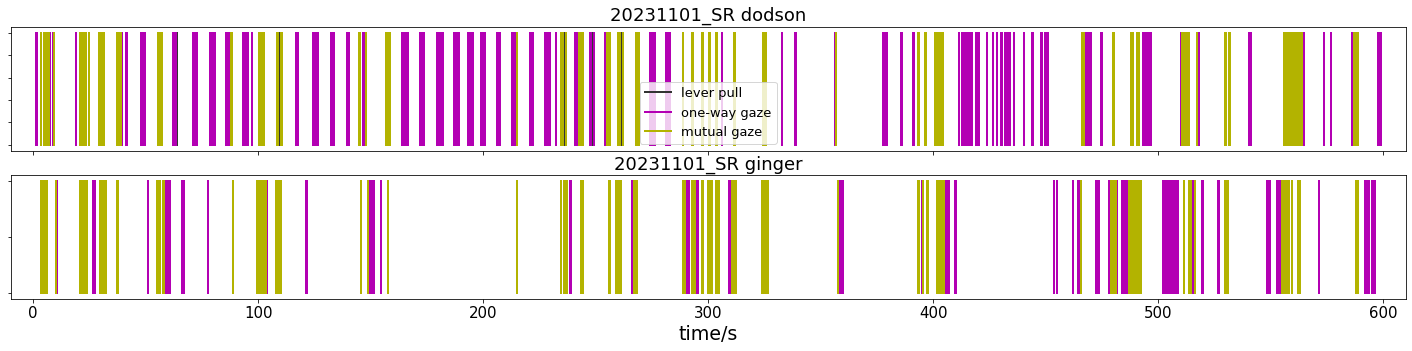

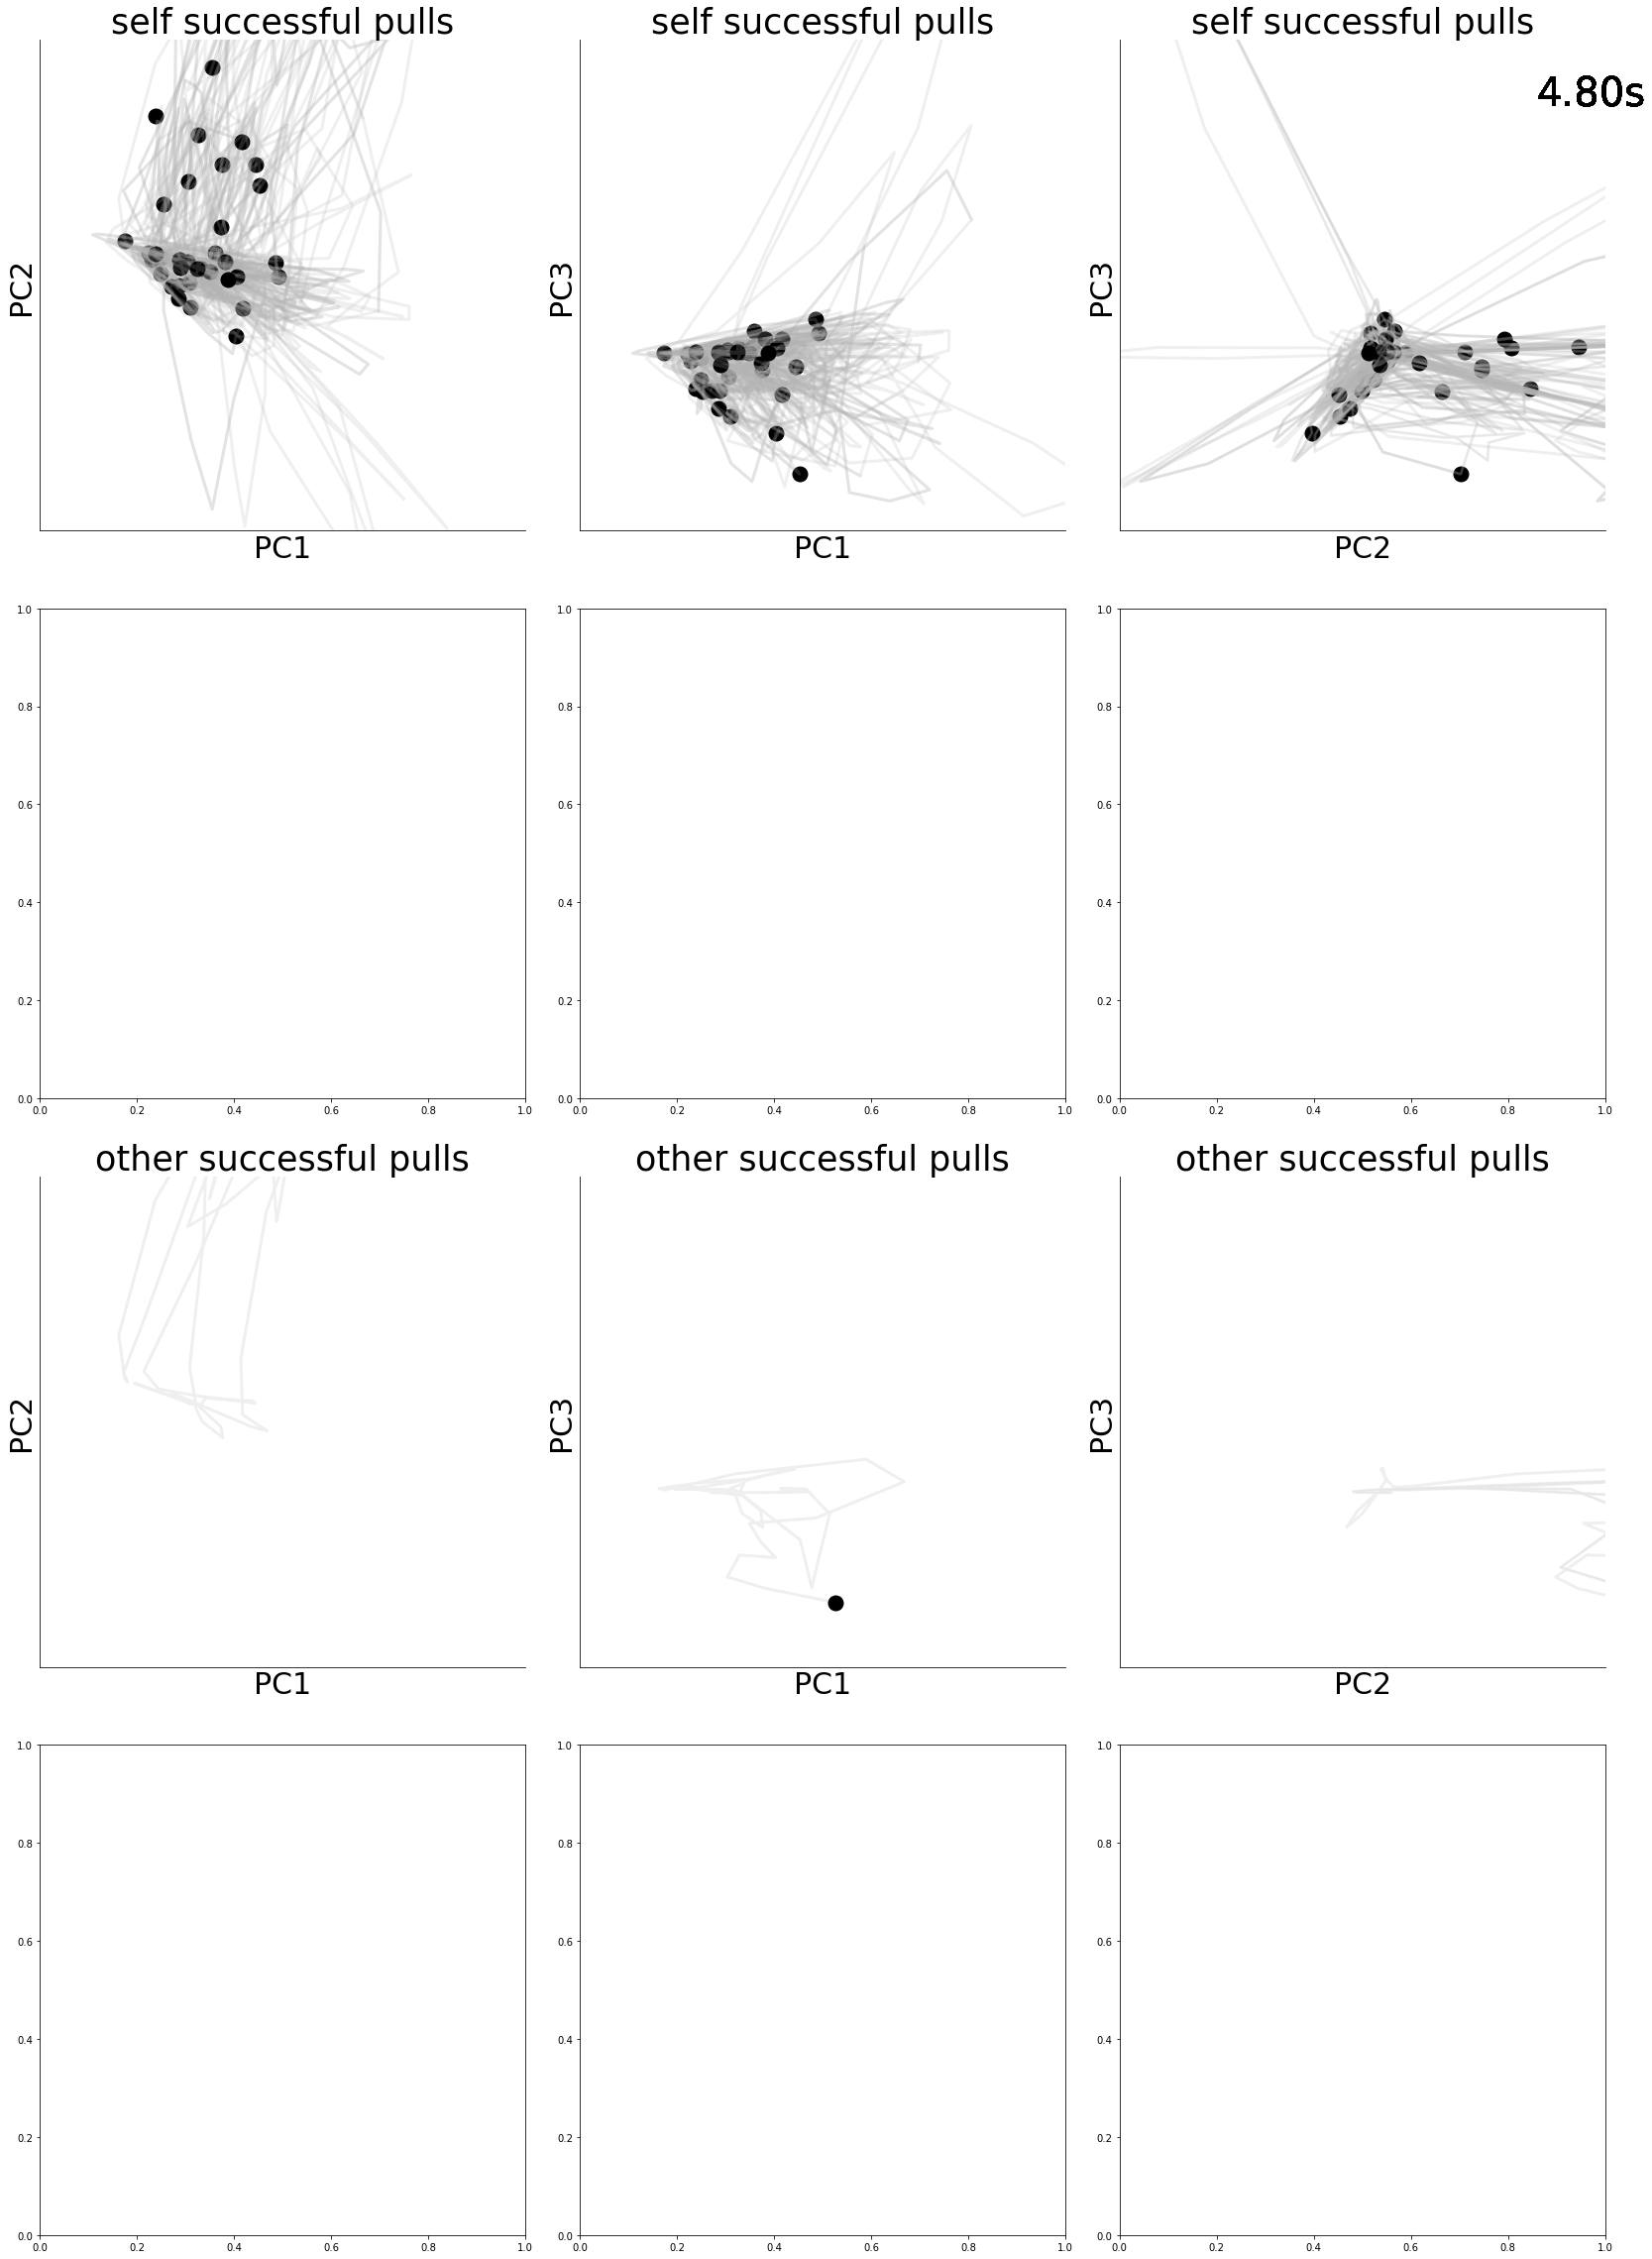

In [17]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        if date_tgt == "20231101_MC":
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
        else:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
        # define successful pulls and failed pulls
        trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
        bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
        #
        time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
        time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
        time_point_pull1_succ = np.round(time_point_pull1_succ,1)
        time_point_pull2_succ = np.round(time_point_pull2_succ,1)
        #
        trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
        bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
        #
        time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
        time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
        time_point_pull1_fail = np.round(time_point_pull1_fail,1)
        time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
            spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
            spike_clusters_data = np.load(spike_clusters_file)
            spike_channels_data = np.copy(spike_clusters_data)
            #
            channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
            channel_maps_data = np.load(channel_maps_file)
            #
            channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
            channel_pos_data = np.load(channel_pos_file)
            #
            clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
            clusters_info_data = pd.read_csv(clusters_info_file,sep="\t") 
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'][icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'][icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'][icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
            channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
            #
            ########
            # # manusally remove bad channel from "20231101_Dodson_withGinger_MC"
            if date_tgt == "20231101_MC":
                bad_channel = channel_to_depth[0,channel_to_depth[1,:]==-38]
                spike_time_data = spike_time_data[spike_channels_data!=bad_channel]
                spike_channels_data = spike_channels_data[spike_channels_data!=bad_channel]
            #########
            
            # calculate the firing rate
            FR_kernel = 0.20 # in the unit of second
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            # _,FR_timepoint_allclusters,FR_allclusters,FR_zscore_allclusters = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
            #                                                                                                spike_clusters_data, spike_time_data)
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
                                                                                         spike_channels_data, spike_time_data)
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
            #
            # # run PCA around the -PCAtwins to PCAtwins for each behavioral events
            PCAtwins = 5 # 5 second
            gaze_thresold = 1.05 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
            savefigs = 1 
            if 0:
                PCA_around_bhv_events(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                              oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                              savefigs,data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            if 1:
                if animal1 == 'dodson':
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull1,time_point_pull2,time_point_pulls_succfail, 
                                      oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
                elif animal2 == 'dodson':
                    time_point_pulls_succfail_rev = time_point_pulls_succfail.copy()
                    time_point_pulls_succfail_rev['pull1_succ'] = time_point_pulls_succfail['pull2_succ']
                    time_point_pulls_succfail_rev['pull1_fail'] = time_point_pulls_succfail['pull2_fail']
                    time_point_pulls_succfail_rev['pull2_succ'] = time_point_pulls_succfail['pull1_succ']
                    time_point_pulls_succfail_rev['pull2_fail'] = time_point_pulls_succfail['pull1_fail']
                    PCA_around_bhv_events_video(FR_timepoint_allch,FR_zscore_allch_np_merged,time_point_pull2,time_point_pull1,time_point_pulls_succfail_rev, 
                                      oneway_gaze2,oneway_gaze1,mutual_gaze2,mutual_gaze1,gaze_thresold,totalsess_time_forFR,PCAtwins,fps,
                                      data_saved_folder,cameraID,animal1_filename,animal2_filename,date_tgt)
            
            
                                                                                                           
            
        # load filtered lfp
        if 1:
            print('load LFP data for '+neural_record_condition)
            lfp_filt_filename = neural_data_folder+neural_record_condition+'/lfp_filt_subsample.txt' # already downsample to 30Hz
            lfp_filt_data_df = genfromtxt(lfp_filt_filename, delimiter=',')
            # aligned to the session start
            lfp_filt_sess_aligned=lfp_filt_data_df[:,int(-neural_start_time_session_start_offset*30):]
            # normalize the activity to 0 - 1
            lfp_filt_sess_aligned = (lfp_filt_sess_aligned-np.min(lfp_filt_sess_aligned))/(np.max(lfp_filt_sess_aligned)-np.min(lfp_filt_sess_aligned))


            
        
        # plot the tracking demo video
        if 0: 
            if 0:
                # all the bhv traces in the same panel
                tracking_video_singlecam_wholebody_withNeuron_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                  spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
            if 1:
                # all the bhv traces are in separate panels
                tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                 lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                 animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                 animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                 video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body,
                                                 spike_time_data,lfp_filt_sess_aligned,spike_channels_data,channel_to_depth)
        
        
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

### plot 
#### plot the PCs

In [ ]:
fig, axs = plt.subplots(12,1)
fig.set_figheight(20*1)
fig.set_figwidth(5*3)

x_lims = [0,totalsess_time_forFR]
PC1min = np.min(FR_zscore_allch_PCs[:,0])
PC1max = np.max(FR_zscore_allch_PCs[:,0])
PC2min = np.min(FR_zscore_allch_PCs[:,1])
PC2max = np.max(FR_zscore_allch_PCs[:,1])
PC3min = np.min(FR_zscore_allch_PCs[:,2])
PC3max = np.max(FR_zscore_allch_PCs[:,2])

for iplotype in np.arange(0,4,1):
    
    if iplotype == 0:
        eventplot  = np.array(time_point_pull1)
        eventplotname = 'animal1_pull'
    elif iplotype == 1:
        eventplot  = np.array(time_point_pull2)
        eventplotname = 'animal2_pull'
    elif iplotype == 2:
        eventplot  = oneway_gaze1
        eventplotname = 'animal1_gaze'
    elif iplotype == 3:
        eventplot  = oneway_gaze2
        eventplotname = 'animal2_gaze'
        

    # plot 1
    nevents = np.shape(eventplot)[0]
    for ievent in np.arange(0,nevents,1):
        axs[0+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC1min,PC1max],'k-')
    axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[0+3*iplotype].set_ylim(PC1min,PC1max)
    #
    axs[0+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,0])
    axs[0+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[0+3*iplotype].set_ylabel('PC1\n'+eventplotname)

    # plot 2
    nevents = np.shape(eventplot)[0]
    for ievent in np.arange(0,nevents,1):
        axs[1+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC2min,PC2max],'k-')
    axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[1+3*iplotype].set_ylim(PC2min,PC2max)
    #
    axs[1+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,1])
    axs[1+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[1+3*iplotype].set_ylabel('PC2\n'+eventplotname)

    # plot 3
    nevents = np.shape(eventplot)[0]
    for ievent in np.arange(0,nevents,1):
        axs[2+3*iplotype].plot([eventplot[ievent],eventplot[ievent]],[PC3min,PC3max],'k-')
    axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[2+3*iplotype].set_ylim(PC3min,PC3max)
    #
    axs[2+3*iplotype].plot(FR_timepoint_allch,FR_zscore_allch_PCs[:,2])
    axs[2+3*iplotype].set_xlim(x_lims[0],x_lims[1])
    axs[2+3*iplotype].set_ylabel('PC3\n'+eventplotname)










In [ ]:
st.zscore(FR_allch['1'])

In [ ]:
plt.plot(FR_timepoint_allch,FR_zscore_allch['1'])
plt.plot(FR_timepoint_allch,FR_zscore_allch['2'])
plt.plot(FR_timepoint_allch,FR_zscore_allch['5'])

In [ ]:
plt.plot(FR_timepoint_allch[FR_timepoint_allch<5],np.transpose(FR_zscore_allch_np_merged[:,FR_timepoint_allch<5]))

In [ ]:
plt.plot(FR_timepoint_allch,np.nanmean(FR_zscore_allch_np_merged,axis=0))

In [ ]:
plt.plot(FR_timepoint_allch,np.nanmean(FR_allch_np_merged,axis=0))